In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
import joblib
import os
from xgboost import XGBClassifier
from utils import one_hot_encode_columns, tune_time_window, calculate_features_with_window
from scipy.stats import norm

In [2]:
# 1. Load and preprocess survey data
anes_survey = 'anes_preprocessed_data.csv'
anes_df = pd.read_csv(anes_survey, low_memory=False)
anes_df = anes_df[['date', 'state', 'gender', 'race', 'age_group', 'edu', 'income', 'vote', 
                   'Yahoo', 'CNN', 'New York Times', 'Breitbart', 'Fox', 'Washington Post',
                   'The Guardian', 'USA Today', 'BBC', 'NPR', 'Buzzfeed']]
categorical_columns = ['state', 'gender', 'race']
anes_df = one_hot_encode_columns(anes_df, categorical_columns)
anes_df['date'] = pd.to_datetime(anes_df['date'])

# 2. Load and preprocess news data
news_sentiment = 'nela_preprocessed_sentiment.csv'
news_sentiment = pd.read_csv(news_sentiment, low_memory=False)
news_iptc = 'nela_preprocessed_iptc.csv'
news_iptc = pd.read_csv(news_iptc, low_memory=False)
iptc_topics = news_iptc['IPTC_topic'].unique().tolist()
news_df = news_sentiment.merge(news_iptc[['id', 'IPTC_topic']], on='id', how='left')
news_categorical_columns = ['IPTC_topic']
news_df = one_hot_encode_columns(news_df, news_categorical_columns)
news_df['date'] = pd.to_datetime(news_df['date'])

# 3. Split data
X = anes_df.drop(columns=['vote']) 
y = anes_df['vote']                
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")

Training set size: (3903, 76), Validation set size: (1301, 76), Test set size: (1301, 76)


In [3]:
y = y.replace({1: 0, 2: 1})
y_train = y_train.replace({1: 0, 2: 1})
y_val = y_val.replace({1: 0, 2: 1})
y_test = y_test.replace({1: 0, 2: 1})

In [4]:
# 4. Define sources, topics, and candidate score columns
sources = ['yahoonews','cnn','thenewyorktimes','breitbart','foxnews','washingtonpost',
           'theguardian','usatoday','bbcuk','npr','buzzfeed']
topics = iptc_topics
candidate_scores = ('trump_hf_sentiment_score', 'biden_hf_sentiment_score')
time_windows = [3, 5, 7]

# 5. Define XGBoost param grid
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 6. Tune time window and XGBoost hyperparameters
best_result, all_results = tune_time_window(
    X_train, y_train, X_val, y_val, news_df,
    time_windows=time_windows,
    topics=topics,
    candidate_scores=candidate_scores,
    sources=sources,
    param_grid=param_grid_xgb,
    estimator_cls=XGBClassifier,
    estimator_kwargs={'random_state': 42, 'eval_metric': 'mlogloss'}
)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END co

In [5]:
print("Best overall result:")
print(f"Time Window: {best_result['time_window']} days")
print(f"Best Parameters: {best_result['best_params']}")
print(f"Training Score: {best_result['train_score']}")
print(f"Validation Score: {best_result['val_score']}")

Best overall result:
Time Window: 3 days
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.7353327633580089
Validation Score: 0.7640276710222905


In [6]:
# 7. Recompute feature matrices using the best time window
final_X_train = calculate_features_with_window(X_train, news_df, best_result['time_window'],
    topics=topics, candidate_scores=candidate_scores, sources=sources)
final_X_val = calculate_features_with_window(X_val, news_df, best_result['time_window'],
    topics=topics, candidate_scores=candidate_scores, sources=sources)
final_X_val = final_X_val[final_X_train.columns]

# 8. Train XGBoost with best params
best_params = best_result['best_params']
xgb_best = XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    eval_metric='mlogloss'
)
xgb_best.fit(final_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

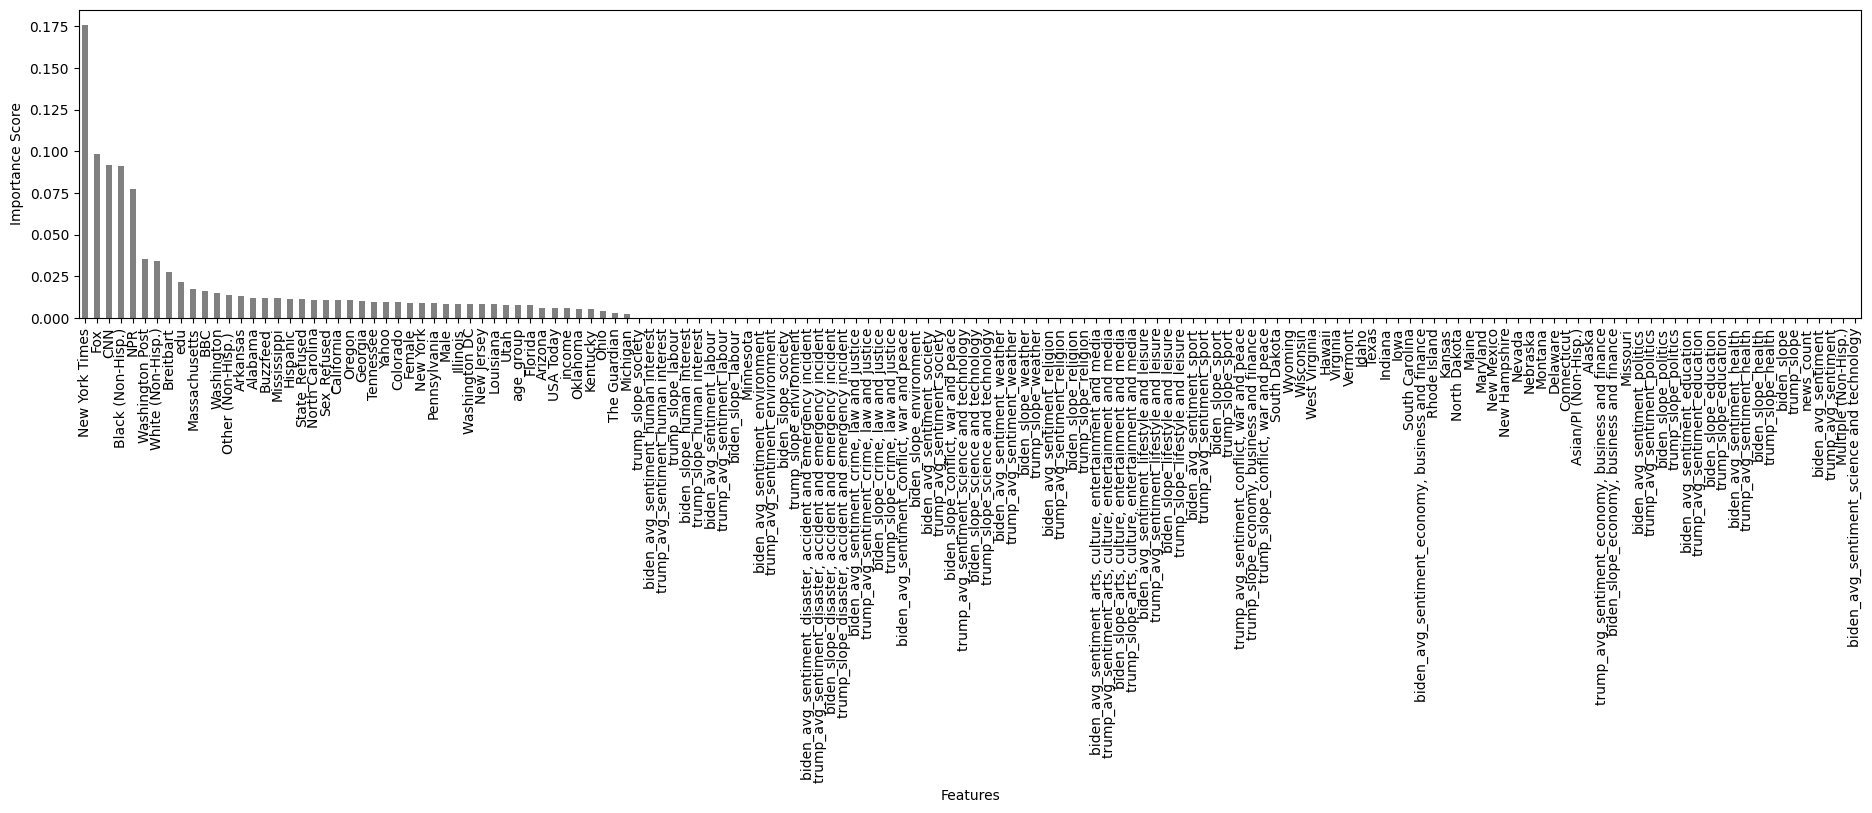

In [7]:
# 9. Feature importance
feature_importance = pd.Series(xgb_best.feature_importances_, index=final_X_train.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar', figsize=(23, 4), color='gray')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

In [8]:
# 10. Validation report
y_val_pred = xgb_best.predict(final_X_val)
val_report = classification_report(y_val, y_val_pred,   output_dict=True)
val_report_df = pd.DataFrame(val_report).T
val_report_df

,precision,recall,f1-score,support
0,0.821270,0.749326,0.783650,742.000000
1,0.701923,0.783542,0.740490,559.000000
accuracy,0.764028,0.764028,0.764028,0.764028
macro avg,0.761597,0.766434,0.762070,1301.000000
weighted avg,0.769990,0.764028,0.765106,1301.000000


In [9]:
# 11. Save model
os.makedirs('models', exist_ok=True)
joblib.dump(xgb_best, 'models/news_content_xgb_model.pkl')

['models/news_content_xgb_model.pkl']

In [10]:
# Prepare test features using the best time window and same attributes
final_X_test = calculate_features_with_window(
    X_test, news_df, best_result['time_window'],
    topics=topics, candidate_scores=candidate_scores, sources=sources
)
final_X_test = final_X_test[final_X_train.columns]  # Ensure column order matches training

# 3. Predict and evaluate
y_test_pred = xgb_best.predict(final_X_test)
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
test_report_df = pd.DataFrame(test_report).T
test_report_df

Test Accuracy: 0.7455803228285934


,precision,recall,f1-score,support
0,0.796736,0.734610,0.764413,731.00000
1,0.690590,0.759649,0.723475,570.00000
accuracy,0.745580,0.745580,0.745580,0.74558
macro avg,0.743663,0.747130,0.743944,1301.00000
weighted avg,0.750231,0.745580,0.746477,1301.00000


In [11]:
# Calculate 95% confidence interval for the test accuracy
n = len(y_test)
z = norm.ppf(0.975)  # 1.96 for 95% confidence
se = np.sqrt((test_accuracy * (1 - test_accuracy)) / n)
margin_of_error = z * se

print(f"Test Accuracy: {test_accuracy:.3f} ± {margin_of_error:.3f} (95% CI)")
print(f"95% CI: [{test_accuracy - margin_of_error:.3f}, {test_accuracy + margin_of_error:.3f}]")

Test Accuracy: 0.746 ± 0.024 (95% CI)
95% CI: [0.722, 0.769]
